# Part 1: Simple Retrieval Model

### Data Elements

Identifying a few feature themes:

Recipe Features
* Preparation complexity:
    * `minutes`
    * `n_steps`
    * `n_ingredients`
* Healthiness:
    * `nutrition`
* Time based:
    *  `submitted` - I don't expect this to be useful
* Text based Features:
    * `name`
    * `tags`
    * `steps`
    * `description`
    * `ingredients`

Interaction Features
* Dependant Features
    * `rating`
* Text based Features:
    * `review`
* Time based:
    * `date` - assume recipes are reviewed shortly after being used (some dishes may be more relevant depending on the day of the week or time of year). May be useful for sequential embeddings too.

### Modelling
There are two options I'd consider for the simple recommender system:
1. Content based filtering using hand-engineered item features (see example [here](https://developers.google.com/machine-learning/recommendation/content-based/basics))
2. Collaborative filtering using matrix factorization (see example [here](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1))


While I could copy some boilerplate code to implement the ALS Matrix Factorization model using `pyspark` I think it would be more useful in the long term to think about how to embed the item based features now, as some of the ideas can be re-used for a more complex deep-learning model using rich item based features.

Ideally I'd also like to implement ScANN for approximate nearest neighbour search to speed up inference time.

### Evalution
We'll use *Mean Average Precision @ K* (or *MAP@K* for short) to evaluate the recommender model. We'll define a relevant item as one a user has reviewed with a rating of 3 or above.

## Content Based Filtering Model

In [2]:
import pandas as pd
import ast

df = pd.read_csv('data/RAW_recipes.csv')

list_cols = [
    "tags",
    "nutrition",
    "steps",
    "ingredients"
]

# read literal strings as lists
for col in list_cols:
    df[col] = df[col].apply(ast.literal_eval)

# convert nutrition info to individual columns
NUTRITION_COLS = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
df[NUTRITION_COLS] = df["nutrition"].tolist()
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[brown ground beef in large pot, add chopped o...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,[place potatoes in a large pot of lightly salt...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [3]:
# Looking at `RAW_recipes.csv` we see some descriptions are split over multiple lines due to line breaks. It looks like pandas may be handling these correctly.?
print(df.loc[df["id"] == 225707]["description"].iloc[0])

i figured that if i had to forgo my jeans to get all dressed up for a dinner party i was giving, why should my salad get off easy? the result is beautiful to look at and  impressed everyone, plus they raved about my decades-old "secret" dressing.  quantities of the vegetable toppings are based on using one large head of iceberg lettuce and standard sized bowl, but i've used iceberg and other salad greens in larger quantities by increasing amounts of vegetable toppings so top is not "half dressed"! (quantities of fresh veggies for "rings" are fairly approximate because salad bowls vary in sizes, but rings should be uniformly shaped)
don't be afraid to try this -- it's not as complicated as it may seem!

re. secret dressing: the recipe makes a good amount, so can be enough for larger salads.  it really is a closely-guarded recipe given me by my cousin, who was friends with a chef who swore her to secrecy. however, i think since my promise of secrecy was made over 30 years ago, the statut

In [4]:
df[df["id"] == 242740]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
1826,90 minute pork side ribs,242740,80,89831,2007-07-26,"[time-to-make, course, main-ingredient, prepar...","[979.0, 123.0, 1.0, 10.0, 116.0, 151.0, 0.0]",11,[place the ribs in a large pot and cover with ...,these might not have the same delicate flavor ...,"[pork side ribs, water, lawry's seasoned salt,...",6,979.0,123.0,1.0,10.0,116.0,151.0,0.0


In [5]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

import numpy as np
import math

# https://alexgude.com/blog/using-sklearn-pipelines-with-pandas-dataframes/#:~:text=Pandas%20is%20a%20popular%20Python,the%20model%20in%20scikit%2Dlearn.


NUMERICAL_FEATURES = ["minutes", "n_steps", "n_ingredients"] + NUTRITION_COLS
TEXT_FEATURES = ["ingredients"]

def abs_log(x):
    return np.log(np.abs(x)+1)

numerical_pipeline = make_pipeline(
    FunctionTransformer(abs_log),
    RobustScaler(quantile_range=(0, 95))
).set_output(transform="pandas")

df_numerical = numerical_pipeline.fit_transform(df[NUMERICAL_FEATURES])
df_numerical = df_numerical.rename(columns={col: f"F_{col}" for col in df.columns})

/Users/rory/miniconda3/envs/deep-learning/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [6]:
column = "ingredients"
n_features = 20
vectorizer = HashingVectorizer(n_features=n_features)
X = vectorizer.fit_transform(df[column].apply(lambda x: ' '.join(x)))
df_text = pd.DataFrame(X.todense(), columns=[f"F_{column}__text_hash_{i}" for i in range(n_features)])

In [7]:
df_item_features = pd.concat([df, df_numerical, df_text], axis=1)

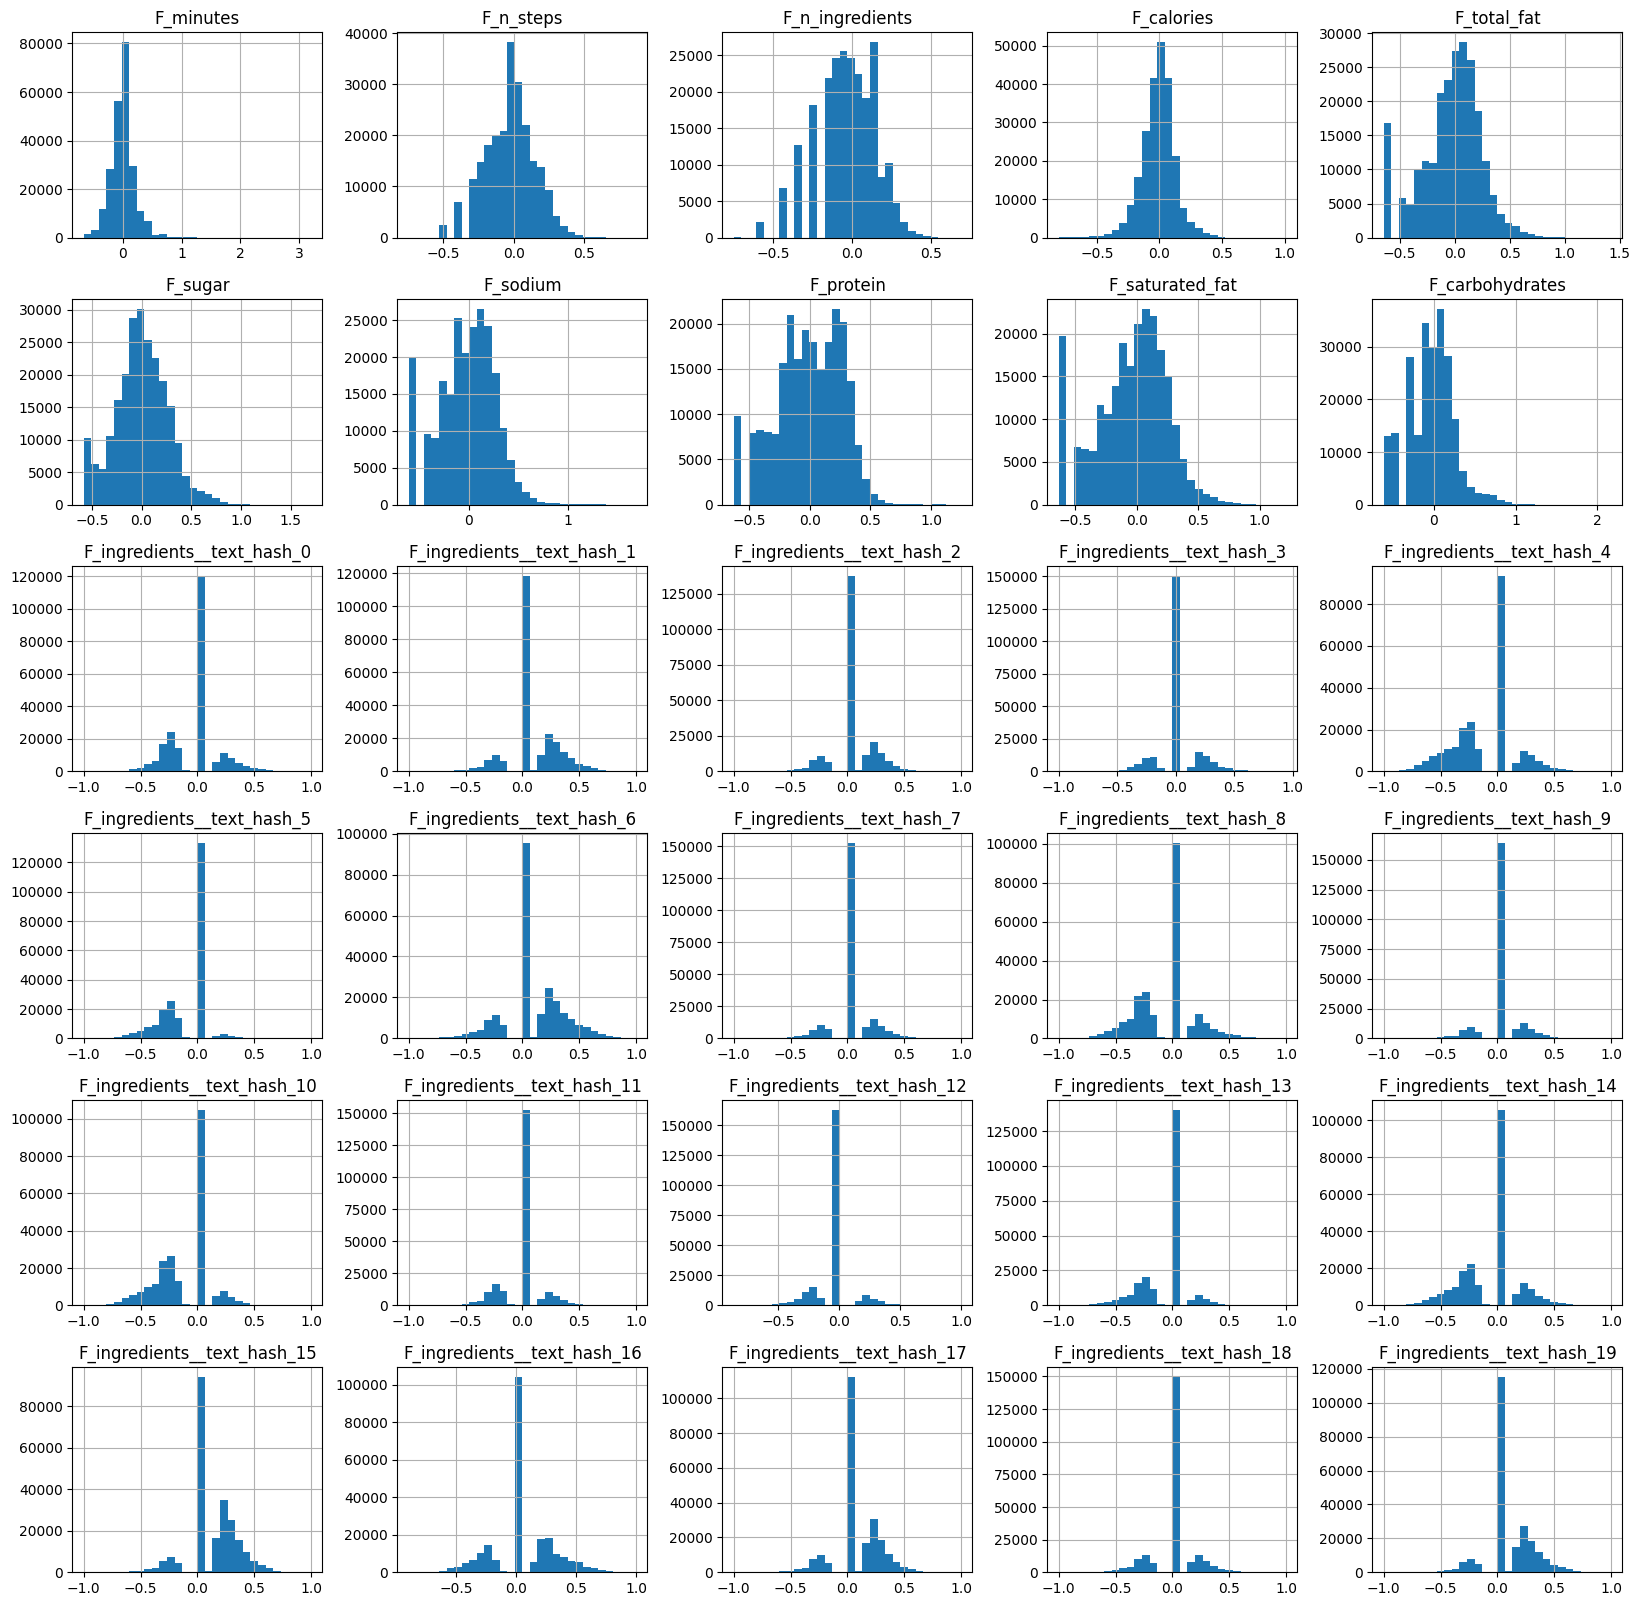

In [8]:
import matplotlib.pyplot as plt

feature_cols = [col for col in df_item_features.columns if col.startswith("F_")]
df_item_features[feature_cols].hist(bins=30, figsize=(20, 20))
plt.show()

How do we evaluate the model?

We'll assume that user preferences don't vary a lot over time.

* Perform a train-test split on the raw interaction data, split temporally
* Generate user embeddings based on the mean of the recipes they like from a training set
* For each user seen in the test set, generate the top K recommendations relevant to them based on cosine similarity

In [9]:
df_interactions = pd.read_csv('data/RAW_interactions.csv')

## Explore Interactions

* We see that over 70% of users have only ever left 1 review - we won't be able to train on any of these so we need a good default embedding

In [10]:
df_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


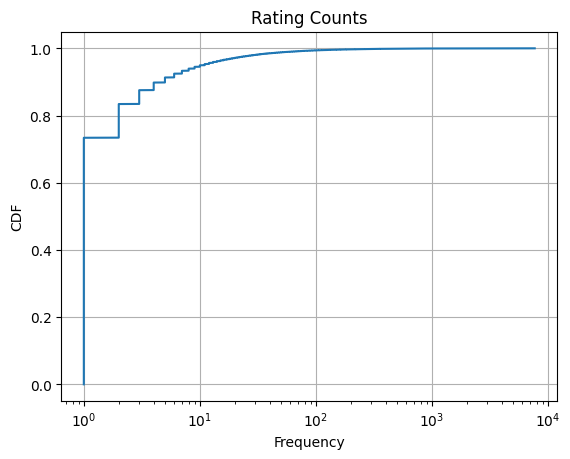

In [11]:
def plot_cdf(series, title, log=True):
    x = series.value_counts()
    x = np.sort(x)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y)
    plt.ylabel("CDF")
    plt.xlabel("Frequency")
    if log:
        plt.xscale("log")
    plt.title(title)
    plt.grid()
    plt.show()

plot_cdf(df_interactions["user_id"], "Rating Counts")

In [12]:
pct = 100 * len(df_interactions.loc[df_interactions["rating"] >= 3]) / len(df_interactions)
print(f"Percentage of ratings 3 or above: {pct}")
df_interactions["rating"].value_counts()

Percentage of ratings 3 or above: 92.24738975968039


5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

In [13]:
def train_test_split(df, date_col="date", test_prop=0.3):
    """
    cutoff = pd.to_datetime(df[date_col]).quantile(1-test_prop)
    df_train = df.loc[pd.to_datetime(df[date_col]) < cutoff]
    df_test = df.loc[pd.to_datetime(df[date_col]) >= cutoff]
    print(f"Training data: {df_train[date_col].min()} to {df_train[date_col].max()}, {len(df_train)} rows")
    print(f"Test data: {df_test[date_col].min()} to {df_test[date_col].max()}, {len(df_test)} rows")
    """
    df_test=df.sample(frac=0.3,random_state=200)
    df_train=df.drop(df_test.index)

    return df_train, df_test

df_int_train, df_int_test = train_test_split(df_interactions)

test_users = df_int_test["user_id"].unique()
train_users = set(df_int_train["user_id"].unique())

missing = 0
for user_id in test_users:
    if user_id not in train_users:
        missing += 1
print(f"Of test set users, {missing} / {len(test_users)} ({round(100 * missing / len(test_users), 2)}%) are not seen in training set")

Of test set users, 52207 / 93259 (55.98%) are not seen in training set


In [14]:
def calculate_user_embeddings(interactions, items, feature_cols):
    df_joined = pd.merge(interactions, items, how='inner', left_on=['recipe_id'], right_on=['id'])
    df_joined = df_joined.loc[df_joined["rating"] >= 3]
    df_user_embeddings = df_joined[["user_id"] + feature_cols].groupby("user_id").mean()
    df_user_embeddings = df_user_embeddings.append(df_user_embeddings[feature_cols].mean().rename(-1))
    return df_user_embeddings

df_user_embeddings = calculate_user_embeddings(df_int_train, df_item_features, feature_cols)
df_user_embeddings.tail()

/var/folders/3f/42x8c1fj10q551mcf53ztdkc0000gn/T/ipykernel_934/507277937.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_user_embeddings = df_user_embeddings.append(df_user_embeddings[feature_cols].mean().rename(-1))


,F_minutes,F_n_steps,F_n_ingredients,F_calories,F_total_fat,F_sugar,F_sodium,F_protein,F_saturated_fat,F_carbohydrates,...,F_ingredients__text_hash_10,F_ingredients__text_hash_11,F_ingredients__text_hash_12,F_ingredients__text_hash_13,F_ingredients__text_hash_14,F_ingredients__text_hash_15,F_ingredients__text_hash_16,F_ingredients__text_hash_17,F_ingredients__text_hash_18,F_ingredients__text_hash_19
user_id,,,,,,,,,,,,,,,,,,,,,
2002371792,-0.050419,0.030834,-0.166665,-0.072029,-0.101446,0.169083,-0.243548,-0.332785,0.016017,-0.027842,...,0.000000,0.000000,-0.408248,0.000000,0.000000,0.000000,-0.408248,0.000000,0.000000,0.408248
2002371843,0.085855,0.190158,0.000000,-0.081502,-0.071175,0.109514,-0.113244,-0.116730,0.069700,-0.094254,...,-0.384900,0.000000,0.000000,0.192450,-0.192450,0.192450,-0.577350,0.192450,-0.384900,-0.192450
2002372464,-0.023453,0.030834,-0.049232,-0.149777,-0.118377,-0.098250,-0.446678,-0.394228,-0.069007,-0.318159,...,-0.316228,0.000000,-0.316228,0.000000,0.000000,0.000000,0.000000,0.000000,0.316228,0.000000
2002372706,-0.120654,0.084879,0.247949,-0.115015,-0.179232,-0.189495,0.000000,-0.246187,-0.277414,-0.094254,...,-0.507093,0.000000,0.000000,0.000000,-0.338062,0.338062,-0.169031,0.169031,0.000000,0.169031
-1,0.022931,0.001400,-0.016309,0.003105,-0.012968,0.007189,0.025627,0.010194,-0.018643,-0.010347,...,-0.138163,-0.008679,-0.026233,-0.066675,-0.091971,0.153681,0.006124,0.093349,-0.019465,0.135142


In [15]:
def lookup_embeddings(user_ids, df_embeddings, feature_cols):
    user_ids_copy = user_ids.copy()
    for i in range(len(user_ids)):
        if user_ids_copy[i] not in df_embeddings.index:
            user_ids_copy[i] = -1
    return df_embeddings.loc[user_ids_copy]

test_embeddings = lookup_embeddings(test_users, df_user_embeddings, feature_cols)
test_embeddings[:5]

,F_minutes,F_n_steps,F_n_ingredients,F_calories,F_total_fat,F_sugar,F_sodium,F_protein,F_saturated_fat,F_carbohydrates,...,F_ingredients__text_hash_10,F_ingredients__text_hash_11,F_ingredients__text_hash_12,F_ingredients__text_hash_13,F_ingredients__text_hash_14,F_ingredients__text_hash_15,F_ingredients__text_hash_16,F_ingredients__text_hash_17,F_ingredients__text_hash_18,F_ingredients__text_hash_19
user_id,,,,,,,,,,,,,,,,,,,,,
-1,0.022931,0.001400,-0.016309,0.003105,-0.012968,0.007189,0.025627,0.010194,-0.018643,-0.010347,...,-0.138163,-0.008679,-0.026233,-0.066675,-0.091971,0.153681,0.006124,0.093349,-0.019465,0.135142
354628,0.004365,-0.057091,-0.059300,0.037490,0.086535,-0.032467,0.093403,0.037948,0.075738,0.047647,...,-0.071513,0.056398,0.038751,-0.091946,-0.097670,0.207000,0.008868,0.154426,0.043365,0.077881
589747,0.056225,0.000000,0.000000,-0.039899,-0.071175,0.217783,-0.068757,-0.213264,0.037870,0.048180,...,-0.288675,0.000000,0.000000,0.000000,0.000000,0.288675,-0.288675,0.288675,-0.288675,0.577350
800480,0.047433,0.038502,-0.017669,-0.024149,-0.046635,-0.016298,-0.008985,-0.040636,-0.003289,-0.078132,...,-0.163360,0.000308,-0.050482,-0.097254,-0.027284,0.150856,-0.029816,0.074473,-0.043878,0.103199
45820,0.016636,0.055946,0.066239,0.017808,0.039282,0.152513,-0.153991,0.033439,-0.007813,-0.053304,...,-0.154400,0.083333,0.069505,0.083333,-0.225467,0.083333,0.041848,0.000000,0.072629,0.095600


In [39]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(df_item_features[feature_cols])
test_recommendations_idx = neigh.kneighbors(test_embeddings, 50, return_distance=False)
# returns recommendations by index, not by recipe id!

In [40]:
def calculate_top_K_precision_recall(test_users, test_recommendations_idx, df_items, df_interactions, ks=[10]):
    
    # create hashmap of user to list of recommendations
    for k in ks:
        assert k <= len(test_recommendations_idx[0]), f"K = {k} must be less than or equal to the number of recommendations provided: {len(test_recommendations_idx[0])}"
        
    user_recommendations_idx = dict(zip(test_users, test_recommendations_idx.tolist()))

    # remove ratings below 3 -> group by into lists of recipe_ids for each user_id -> turn into dict {user: interactions} 
    user_interactions = df_interactions.loc[df_interactions["rating"] >= 3].groupby("user_id")["recipe_id"].apply(list).to_dict()
    tps = [0 for _ in ks]
    total = 0
    for user, interactions in user_interactions.items():
        for recipe in interactions:
            total += 1
            # check if recipe in top K recommendations for user
            # recommendations are given by index, not by recipe id, so we need to convert them
            user_recommendations = df_items.iloc[user_recommendations_idx[user]]["id"].tolist()
            for i, k in enumerate(ks):
                if recipe in user_recommendations[:k]:
                    tps[i] += 1
    for i, k in enumerate(ks):
        recall = round(100 * tps[i] / total, 3)
        precision = round(100 * tps[i] / (k * len(user_recommendations_idx)), 3)
        print(f"Top {k} Precision: {precision}%, Recall: {recall}%")

print("Model Recommendations")
calculate_top_K_precision_recall(test_users, test_recommendations_idx, df_item_features, df_int_test, ks=[5, 10, 50])

Model Recommendations
Top 5 Precision: 0.008%, Recall: 0.012%
Top 10 Precision: 0.007%, Recall: 0.02%
Top 50 Precision: 0.005%, Recall: 0.069%


In [41]:
# test random recommendations
random_recommendations_idx = np.random.randint(0, len(df_item_features), size=test_recommendations_idx.shape)

print("Random Recommendations")
calculate_top_K_precision_recall(test_users, random_recommendations_idx, df_item_features, df_int_test, ks=[5, 10, 50])

Random Recommendations
Top 5 Precision: 0.003%, Recall: 0.004%
Top 10 Precision: 0.002%, Recall: 0.006%
Top 50 Precision: 0.001%, Recall: 0.022%


We do better than random chance - so a good sign our model is learning something useful!

We'll check the recommendations are sensible by testing with a few examples. First we'll imagine a user who has likes some meaty dishes.

In [18]:
def get_recommendations(liked_recipe_ids, df_item_embeddings, feature_cols, nn_model, n_recommendations=10):
    item_index = df_item_embeddings.set_index("id")
    embedding = item_index.loc[liked_recipe_ids][feature_cols].mean()
    # embedding needs to be reshaped to (1, n_recommendations)
    recommendations_idx = nn_model.kneighbors(embedding.to_numpy().reshape(1, -1), n_recommendations, return_distance=False)
    # recommendations will be a (1, n_recommendations) shape array
    recommended_items = item_index.iloc[recommendations_idx.flatten()][["name"]]
    return recommended_items.reset_index()

liked_items = [
    63986,      # chicken lickin  good  pork chops
    13671,      # 60 minute oven sirloin steak stew
    242740,     # 90 minute pork side ribs
    109758      # a golden chicken
]

get_recommendations(
    liked_recipe_ids=liked_items,
    df_item_embeddings=df_item_features,
    feature_cols=feature_cols,
    nn_model=neigh
)

/Users/rory/miniconda3/envs/deep-learning/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,id,name
0,370621,meatballs savory meatballs in gravy
1,480583,sara s mustard chicken
2,224532,crispy rice chicken
3,176626,tasty mince ground beef
4,42200,e z roast chicken
5,502831,oven roasted wings of chicken
6,386277,tasty sauteed chicken breasts
7,503412,greek chicken lemonata
8,28667,creamed ground beef sos
9,337312,lancaster county meatballs


Trying a second example with mostly desert based recipes.

In [23]:
liked_items = [
    70971,   # bananas 4 ice cream  pie
    107699,  # deep fried dessert thingys
    52804,   # jiffy  extra moist carrot cake
    44895,   # symphony  brownies
]

get_recommendations(
    liked_recipe_ids=liked_items,
    df_item_embeddings=df_item_features,
    feature_cols=feature_cols,
    nn_model=neigh
)

/Users/rory/miniconda3/envs/deep-learning/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,id,name
0,150177,cinnamon loaves
1,138385,charmie s snickerdoodles
2,11962,white turtle cake
3,260086,chocoflan
4,38228,lemon luscious pie
5,443070,milder pumpkin pie
6,81913,apple pie with no apples
7,495189,harriet s cookies brown sugar shortbread bars...
8,43802,cherry pumpkin bread
9,418013,chocolate lemon cream bars


When I combine both set of liked items, the recommendations I get are pretty much nonsense. When a user's liked history is quite homogenous, the recommendations are quite good. But when items from multiple groups are introduced, it seems averaging the item embeddings to create user embeddings this way can put us in a part of the embeddings space that is similar to none of their likings.

A few ways we could improve this system:
1. A better heuristic might be to make recommendations based on individual items sampled from those the user has liked - that way we don't get the problem of averaging out into a random place in the embedding space.
2. To avoid the same recommendations being made given the same input, we could introduce some randomness based on the KNN distance from the input embedding (closer items are recommended with greater probability)

In [42]:
liked_items = [
    63986,      # chicken lickin  good  pork chops
    13671,      # 60 minute oven sirloin steak stew
    242740,     # 90 minute pork side ribs
    109758,     # a golden chicken
    70971,      # bananas 4 ice cream  pie
    107699,     # deep fried dessert thingys
    52804,      # jiffy  extra moist carrot cake
    44895,      # symphony  brownies
]

get_recommendations(
    liked_recipe_ids=liked_items,
    df_item_embeddings=df_item_features,
    feature_cols=feature_cols,
    nn_model=neigh
)

/Users/rory/miniconda3/envs/deep-learning/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,id,name
0,53379,spicy sausage soup with hominy
1,399826,mushroom meatball soup
2,67838,haluska cabbage noodles
3,113170,creamy cheesy chicken rice
4,167838,asparagus on toast
5,134911,alsace onion flan
6,508765,chicken enchiladas with green chili sour cream...
7,127380,dad s beef stroganoff
8,332612,chickpea stew with spinach and chorizo
9,291472,creamed chicken and biscuits


## Topic Modelling

Even though the hash vectorizor works reasonably well, I'm curious to see whether we can improve the encoding of the test based columns by capturing some semantic meaning. We could try this with some basic topic modelling.

We'll use the LDA (Latent Dirichlet Allocation) model to extract topics from each of the text fields:
* `steps`
* `ingredients`
* `description`

We can clearly see groups which make sense semantically. Looking at a few examples from the `steps` topics:
* Topic 1: clearly roast dishes (my favourite!)
* Topic 2: baking/desserts
* Topic 3: possibly salads

We clearly see a few overlapping topics - e.g. Topic 6 also looks related to Baking. This is probably a sign that we have too many components.

In principle, these features could be used in place of the hash vectorizer but I won't bother for now.

I haven't done a deep dive on LDA theory (I'd studied this at University, but it's long since been lost on me), maybe for another time.

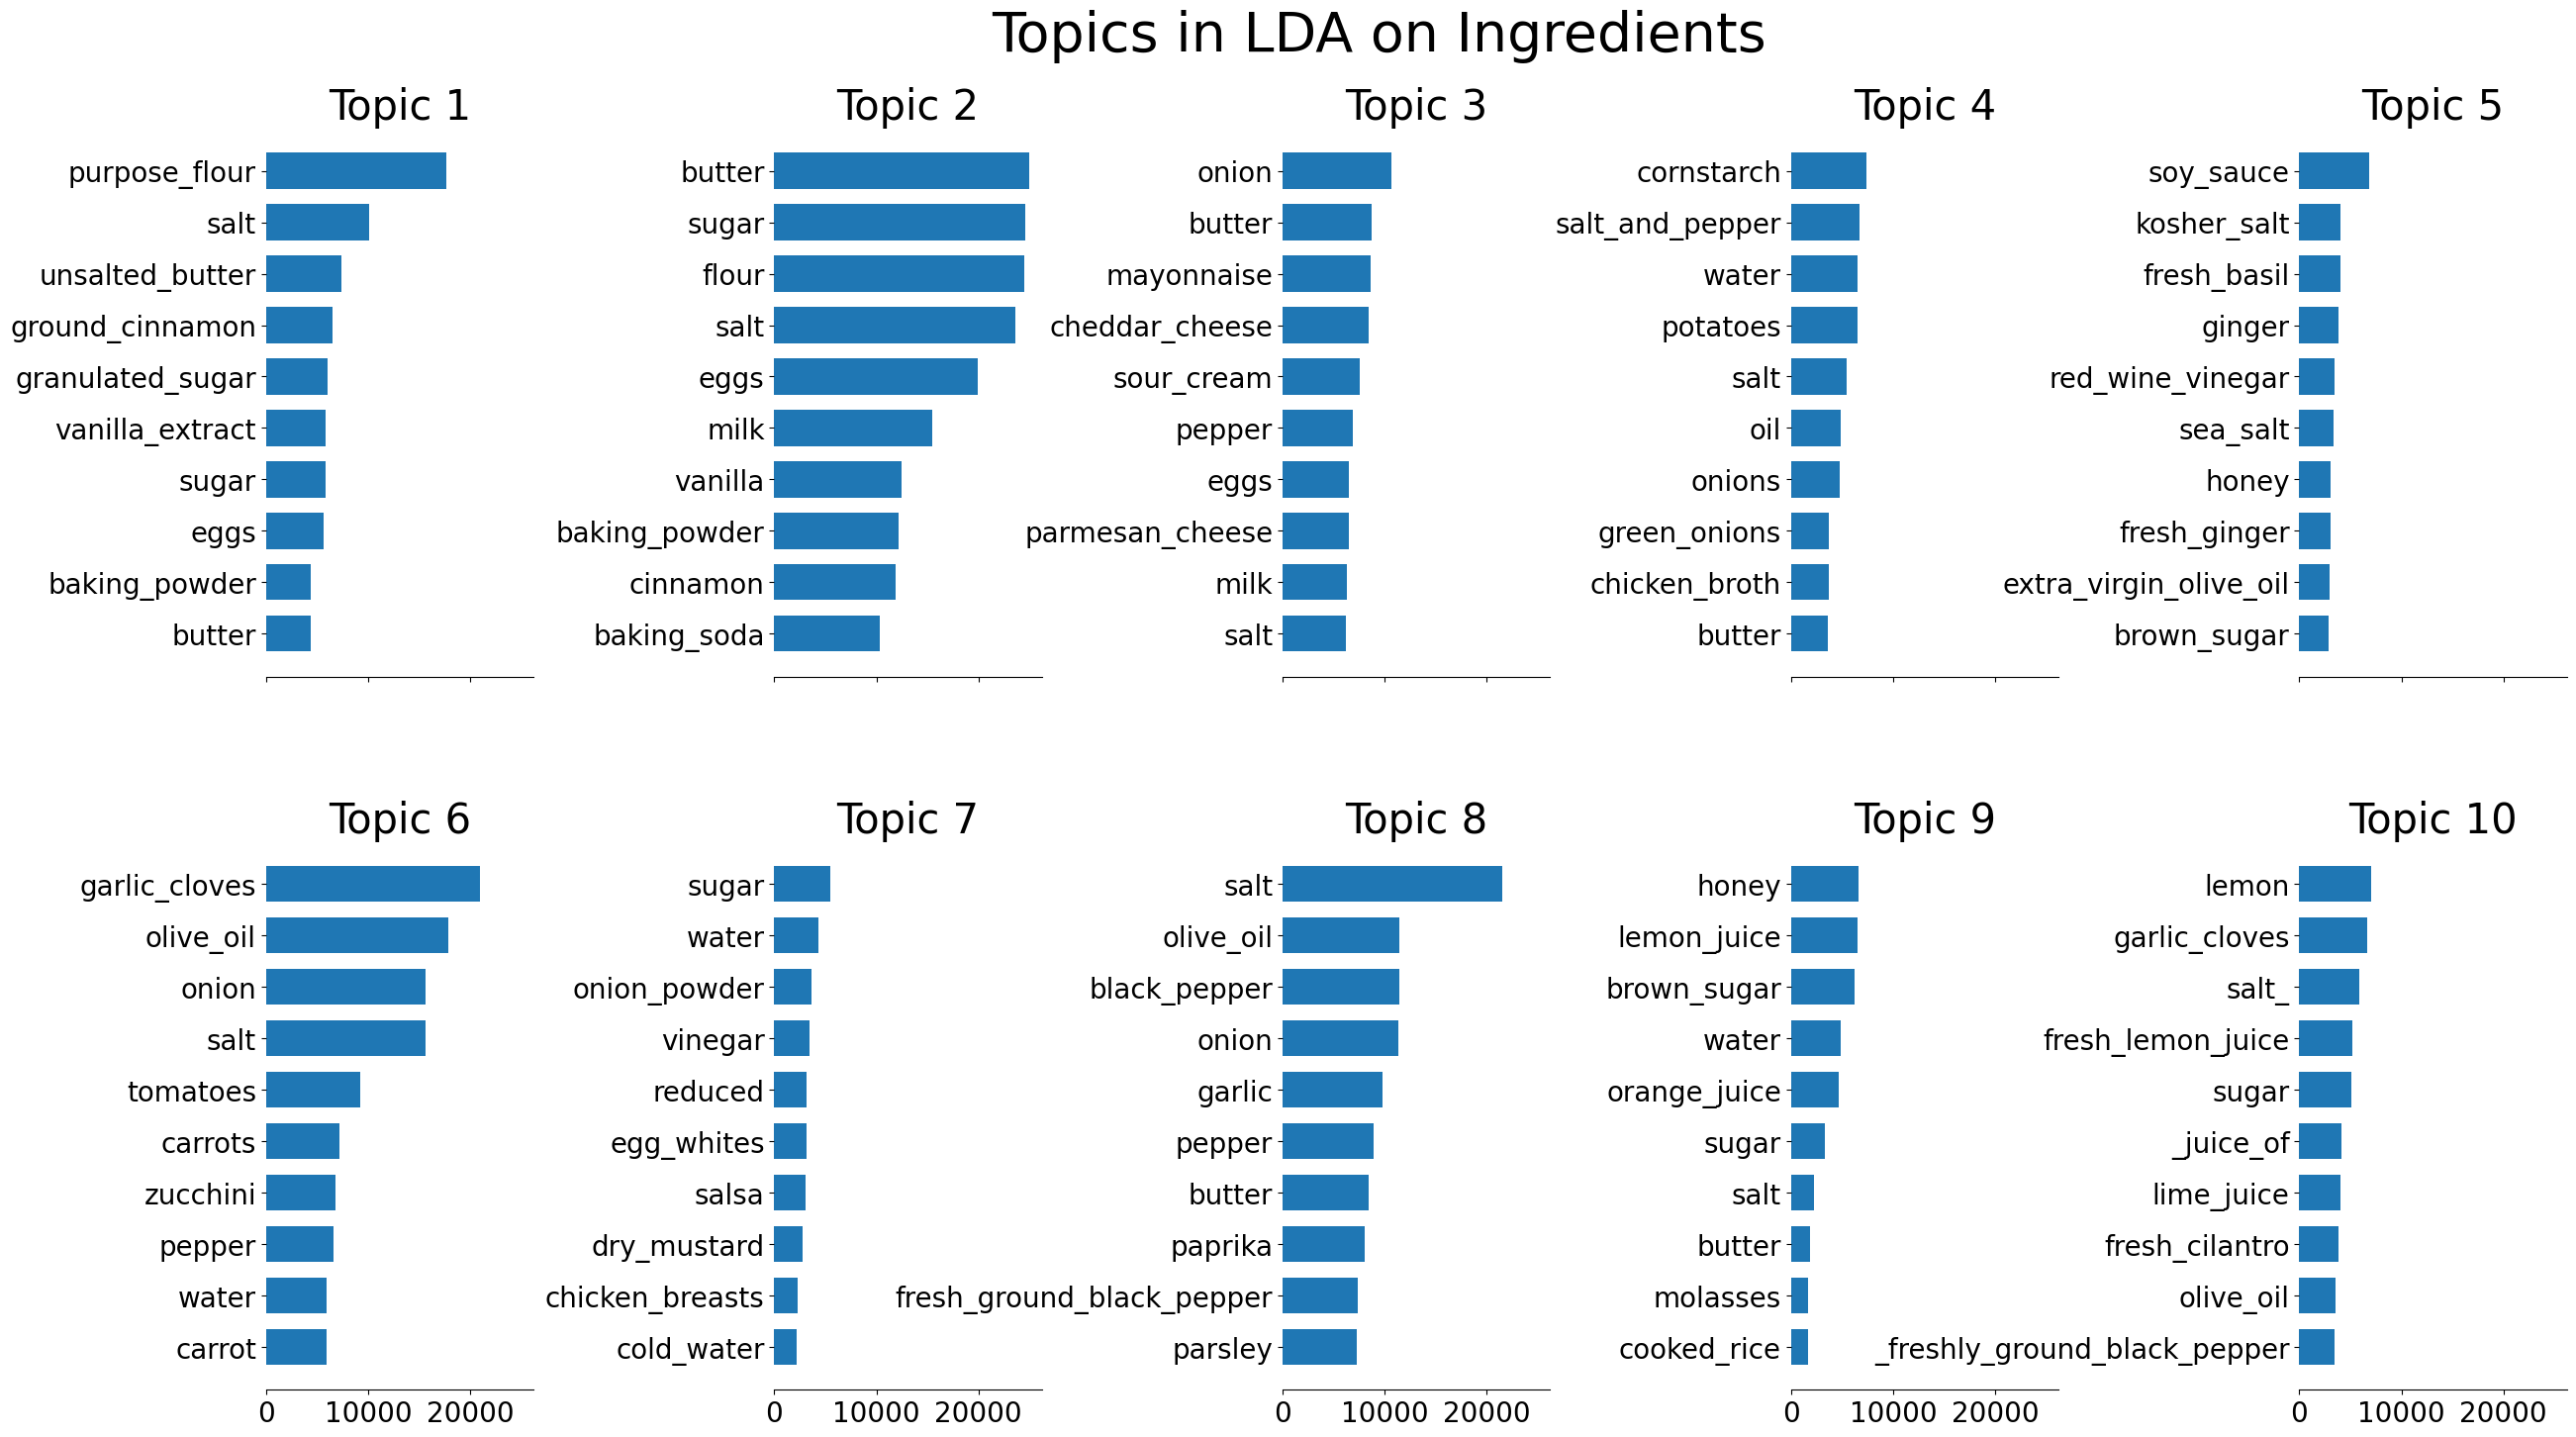

In [19]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

def preprocess(x):
    return " ".join([s.replace(" ", "_") for s in x])

data_samples = df["ingredients"].apply(preprocess)

n_components = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english",
)
tf = tf_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA on Ingredients")

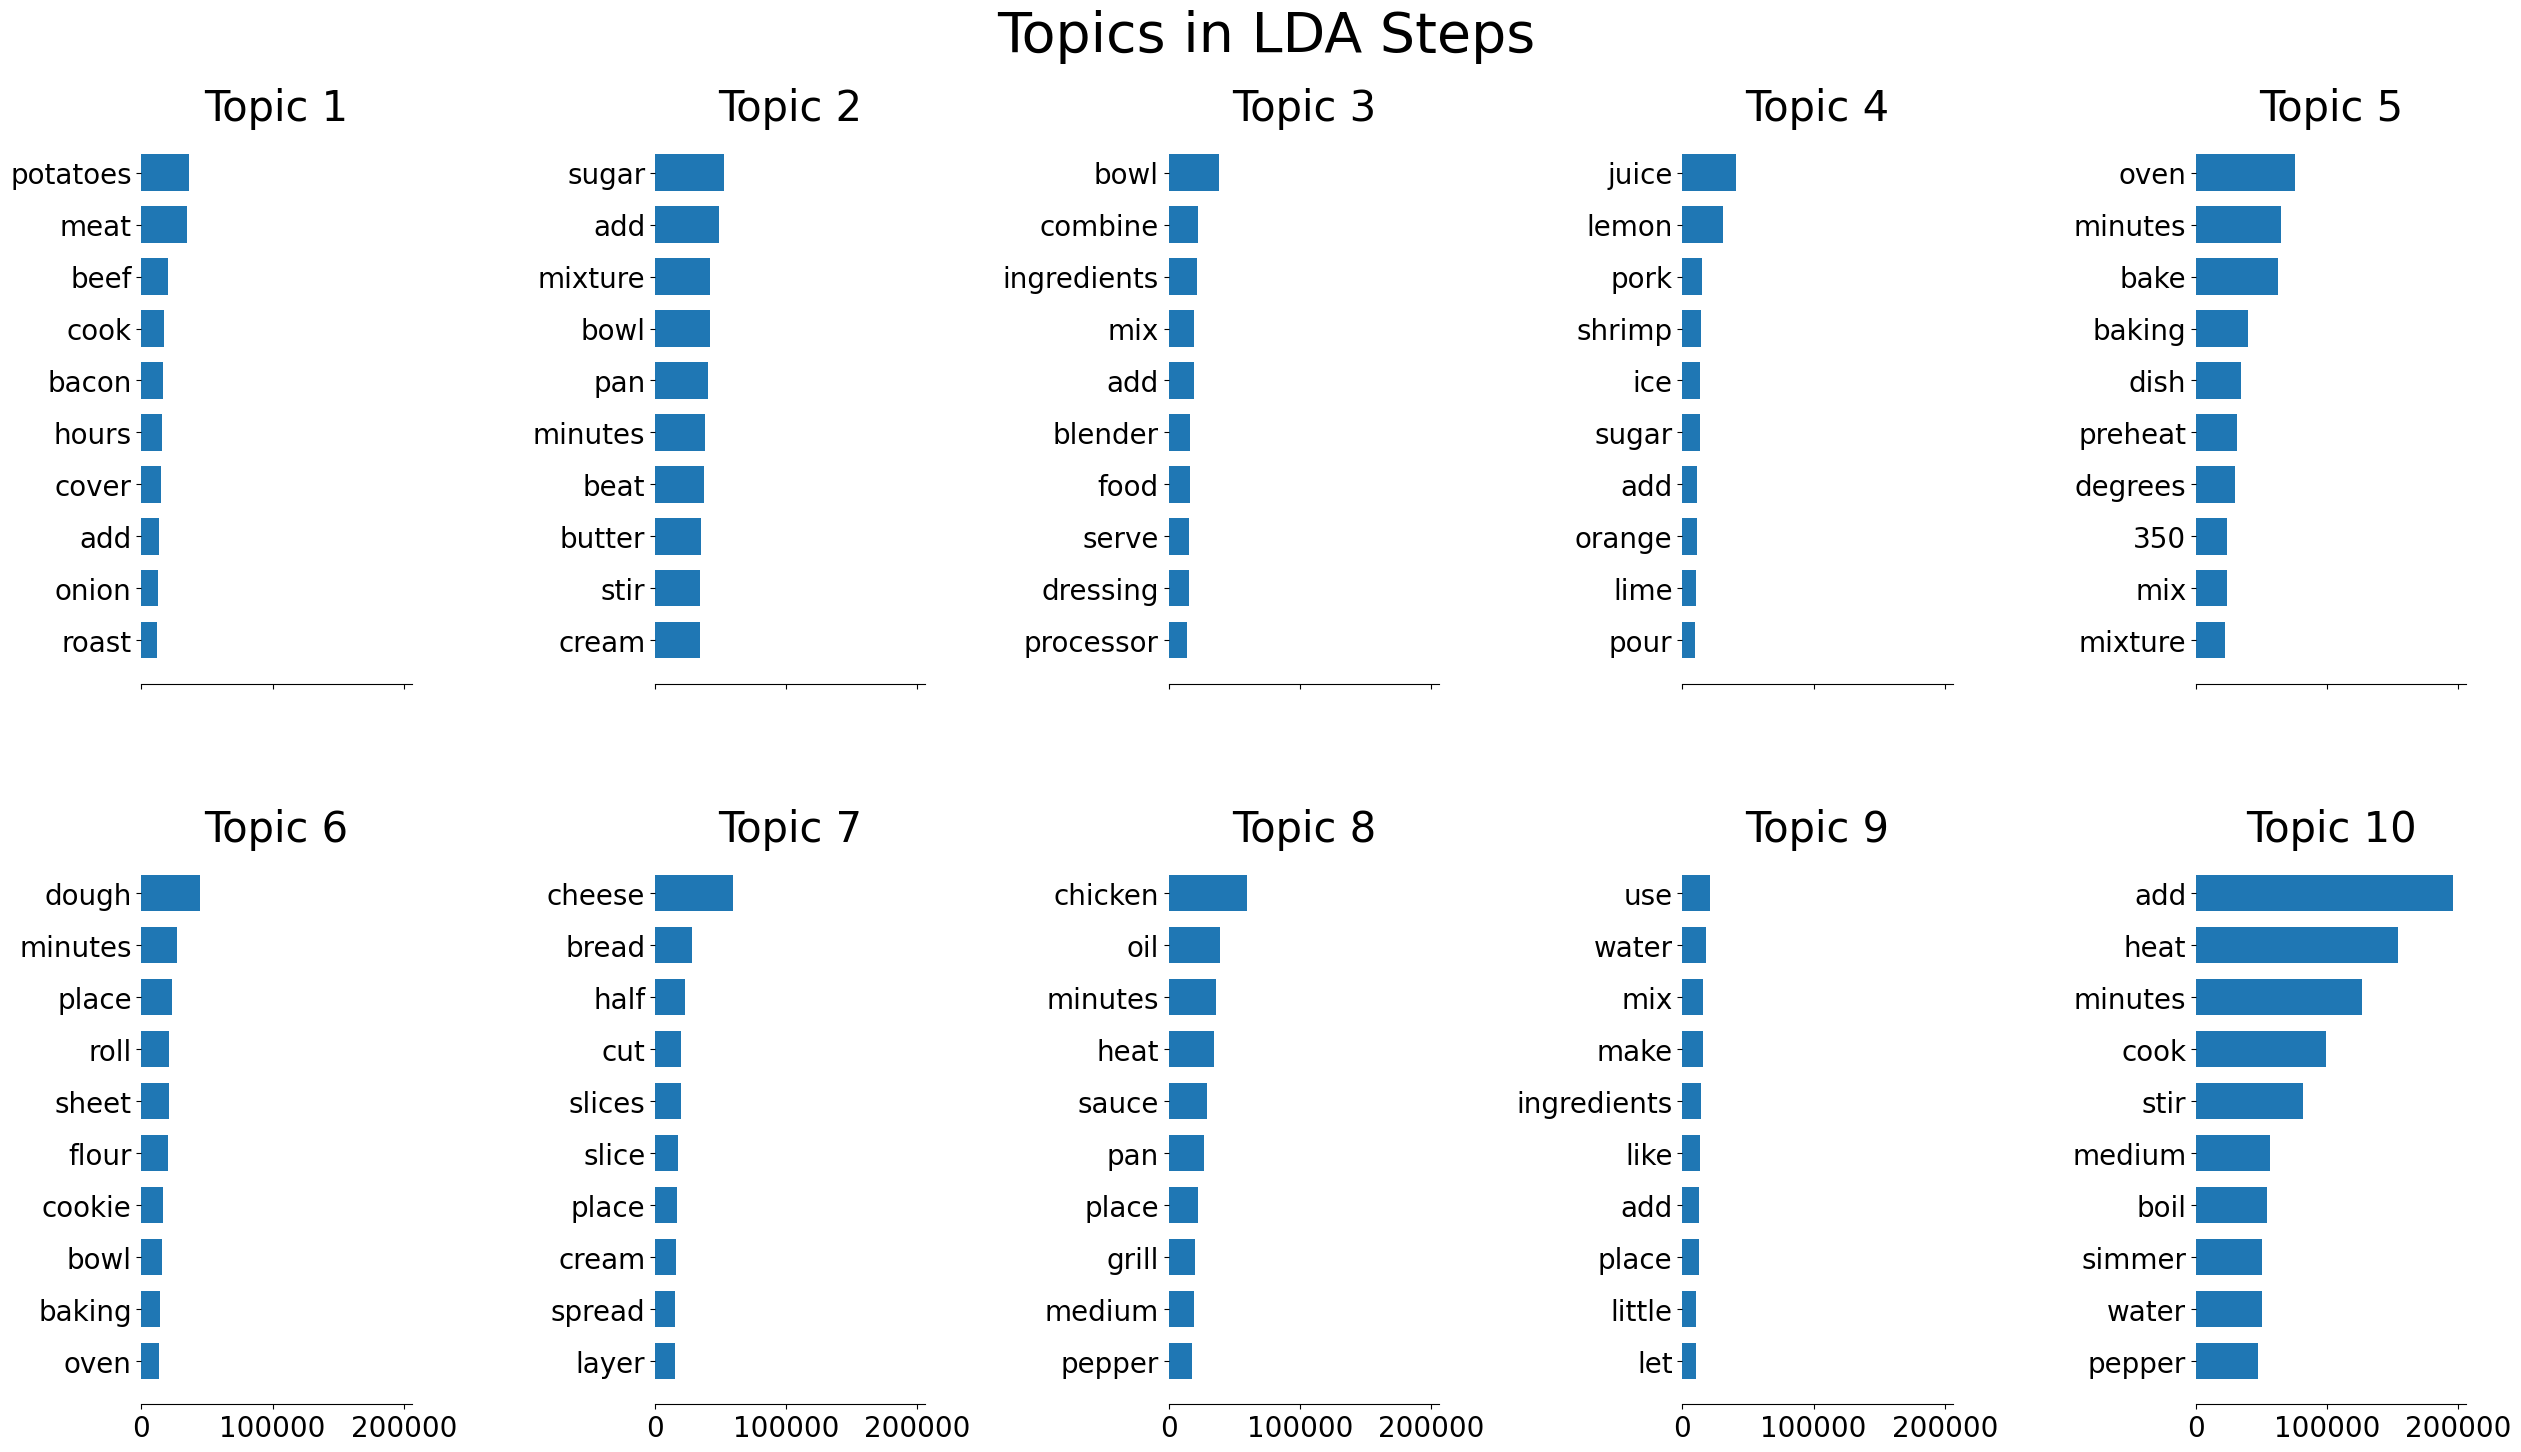

In [20]:
data_samples = df["steps"].apply(lambda x: ' '.join(x))

n_components = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english",
)
tf = tf_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA Steps")

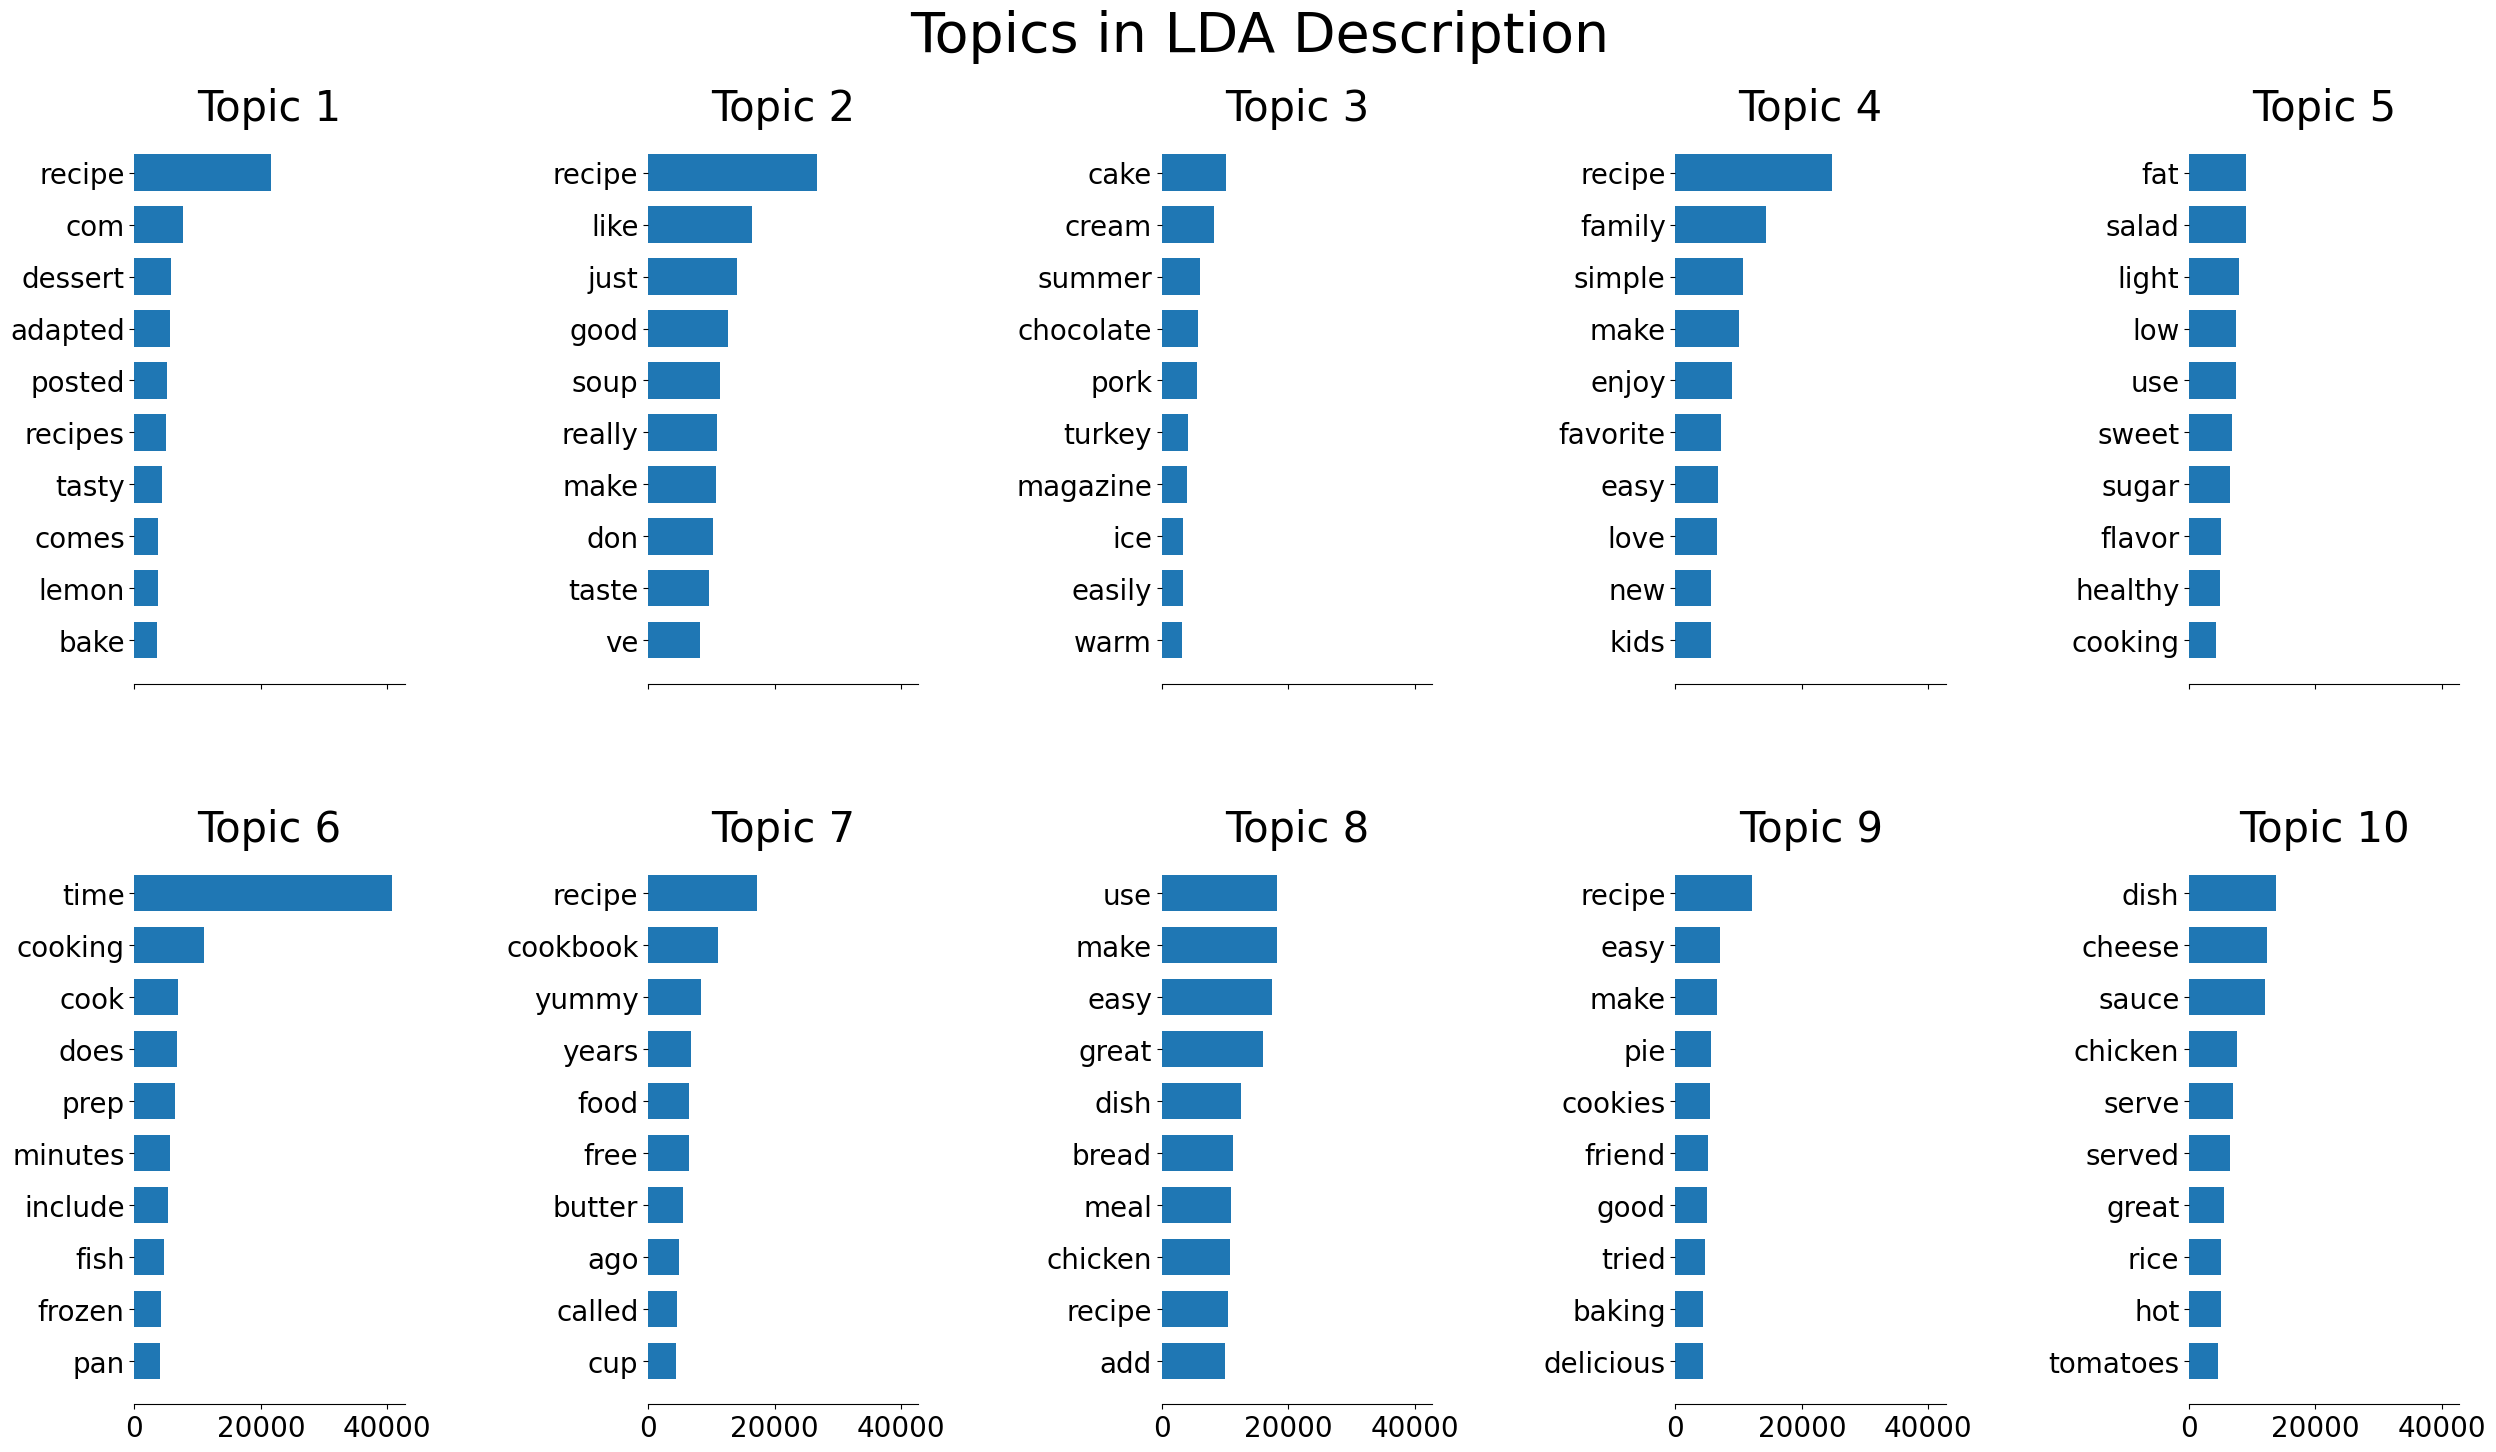

In [21]:
data_samples = df["description"].fillna("")

n_components = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english",
)
tf = tf_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA Description")

### Summary

What have we learned?
1. Gained a better understanding of the rich features available for more complex modelling
2. Gained a better intuition of the metrics which can be used to measure recommender systems (precision/recall at K)
3. Explored a number of ways of encoding text data without neural methods.
4. Hand engineered features and the use of simple KNN is an easy way to generate pretty good item based recommendations, but struggle when trying to capture more complex, multi-faceted user preferences. Learned embeddings like Matrix Factorization and Neural Networks might do better at this (but I wanted to hack together something quick and dirty).

My next steps could go 1 of 2 ways:
* Build a more complex neural recommender system
* Setup a simple front-end and backend API so I can serve and demo this system, and build on further with more complex models.